In [ ]:
# import renabap data
# import riesgo hidrico
# start with areal weighted estimate of family exposure
# then use basic dasymetric mapping--compare worldpop and GHSL data from the most recent year available
# oh yeah, and then we need to count this per cuenca, too, which is just summing per region

In [1]:
import pandas as pd
import geopandas as gpd

In [ ]:
# read in geojson of renabap data from here: https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson
# confirm that itś in the right CRS (postgar whatever)

In [1]:
import requests
import geopandas as gpd
from io import StringIO

USE_CRS = 'EPSG:5349'

In [2]:
response = requests.get('https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson')
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap['provincia'] == 'Buenos Aires']
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [3]:
peligro_path = '/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson'
peligro = gpd.read_file(peligro_path)
peligro = peligro.to_crs(USE_CRS)

In [4]:
# This keeps entire polygons that intersect (doesn't clip them)
renabap_pba_intersect = gpd.sjoin(renabap_pba, peligro, how='inner', predicate='intersects')

# validate all geometries and add a 2.5m buffer
renabap_pba_intersect = renabap_pba_intersect.copy()
renabap_pba_intersect['geometry'] = renabap_pba_intersect.geometry.buffer(1)
renabap_pba_intersect = renabap_pba_intersect[renabap_pba_intersect.geometry.is_valid]


In [ ]:
import geopandas as gpd
from tobler.area_weighted import area_interpolate

# Ensure both GeoDataFrames have the same CRS
if renabap_pba_intersect.crs != peligro.crs:
    peligro = peligro.to_crs(renabap_pba_intersect.crs)

# Get unique hazard levels
hazard_levels = peligro['PELIGROSID'].unique()

# Initialize output columns in renabap_pba_intersect
for level in hazard_levels:
    renabap_pba_intersect[f'porcion_{level}'] = 0.0

# For each hazard level, calculate the portion of each barrio that falls within it
for level in hazard_levels:
    # Filter hazard polygons for this level
    hazard_subset = peligro[peligro['PELIGROSID'] == level].copy()
    
    if not hazard_subset.empty:
        # Add dummy variable with value 1 for each hazard polygon
        hazard_subset['hazard_area'] = 1
        
        # Interpolate hazard area to barrios (this gives us the proportion)
        results = area_interpolate(
            source_df=hazard_subset,
            target_df=renabap_pba_intersect,
            extensive_variables=['hazard_area']
        )
        
        # This gives us the portion of each barrio that overlaps with this hazard level
        renabap_pba_intersect[f'porcion_{level}'] = results['hazard_area']

# Display results
print("Barrios with hazard exposure portions:")
renabap_pba_intersect[['nombre_barrio', 'familias_aproximadas'] + [f'porcion_{level}' for level in hazard_levels]].head(25)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each hazard level
for i, level in enumerate(hazard_levels):
    data = renabap_pba_intersect[f'porcion_{level}'] * 100  # Convert to percentage
    axes[i].hist(data, bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Portion of Barrios in {level.upper()} Hazard')
    axes[i].set_xlabel('Portion (%)')
    axes[i].set_ylabel('Number of Barrios')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for level in hazard_levels:
    data = renabap_pba_intersect[f'porcion_{level}'] * 100
    print(f"{level.upper()}: Mean={data.mean():.1f}%, Max={data.max():.1f}%, Barrios with >0%: {(data > 0).sum()}")

In [ ]:
# Calculate families exposed to each hazard level
for level in hazard_levels:
    renabap_pba_intersect[f'familias_expuestas_{level}'] = (
        renabap_pba_intersect[f'porcion_{level}'] * renabap_pba_intersect['familias_aproximadas']
    )

# Summary
total_familias = renabap_pba_intersect['familias_aproximadas'].sum()
print(f"Total families in dataset: {total_familias:.0f}")

for level in hazard_levels:
    total_exposed = renabap_pba_intersect[f'familias_expuestas_{level}'].sum()
    print(f"Total families exposed to {level} hazard: {total_exposed:.0f}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors based on your specifications
colors = {
    'alta': '#1a2b4a',      # hsla(221, 83%, 25%, 0.7) -> dark blue
    'media': '#4a6b9a',     # hsla(221, 83%, 45%, 0.7) -> medium blue  
    'baja': '#7a9bca'       # hsla(221, 83%, 65%, 0.7) -> light blue
}

# Define pink colors for exposure (exact hsla values you specified)
pink_colors = {
    'alta': '#4a1a2a',      # hsla(330, 83%, 25%, 0.7) -> dark pink
    'media': '#7a4a6a',     # hsla(330, 83%, 45%, 0.7) -> medium pink
    'baja': '#aa7a9a'       # hsla(330, 83%, 65%, 0.7) -> light pink
}

# Create custom pink colormap using your exact colors
pink_cmap = LinearSegmentedColormap.from_list('pink_custom', 
                                             [pink_colors['baja'], pink_colors['media'], pink_colors['alta']])

# Plot map for each hazard level
for i, level in enumerate(hazard_levels):
    # First plot the hazard polygons (peligro) as background
    peligro_subset = peligro[peligro['PELIGROSID'] == level]
    if not peligro_subset.empty:
        peligro_subset.plot(
            ax=axes[i],
            color=colors[level],
            alpha=0.7
        )
    
    # Then plot the barrio exposure data on top with your exact pink colors
    renabap_pba_intersect.plot(
        column=f'familias_expuestas_{level}',
        ax=axes[i],
        legend=False,
        cmap=pink_cmap,
        alpha=0.8,
        missing_kwds={'color': 'none', 'alpha': 0}
    )
    
    axes[i].set_title(f'Families Exposed to {level.upper()} Hazard')
    axes[i].axis('off')

# Create custom legend for hazard levels (blue)
hazard_legend_elements = [
    mpatches.Patch(color=colors['alta'], label='Alta', alpha=0.7),
    mpatches.Patch(color=colors['media'], label='Media', alpha=0.7),
    mpatches.Patch(color=colors['baja'], label='Baja', alpha=0.7)
]

# Create custom legend for exposure levels (pink gradient using your exact colors)
exposure_legend_elements = [
    mpatches.Patch(color=pink_colors['baja'], label='Low Exposure'),
    mpatches.Patch(color=pink_colors['media'], label='Medium Exposure'),
    mpatches.Patch(color=pink_colors['alta'], label='High Exposure')
]

# Add legends at the bottom
fig.legend(handles=hazard_legend_elements, loc='lower left', bbox_to_anchor=(0.1, 0.02), title='Hazard Zones')
fig.legend(handles=exposure_legend_elements, loc='lower right', bbox_to_anchor=(0.9, 0.02), title='Family Exposure')

plt.tight_layout()
plt.show()

# Print summary statistics for each map
for level in hazard_levels:
    data = renabap_pba_intersect[f'familias_expuestas_{level}']
    print(f"{level.upper()}: Max={data.max():.0f} families, Mean={data.mean():.1f} families, Barrios with exposure: {(data > 0).sum()}")

In [93]:
import rioxarray
import dask.array as da
from shapely.geometry import box

# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    '/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif',
    chunks={'x': 1024, 'y': 1024}  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl = ghsl.rio.reproject(
    dst_crs=USE_CRS
)

# Clip to renabap_pba_intersect bounding box using streaming
bounding_box = box(*renabap_pba_intersect.total_bounds)  # Create a box from the bounding box coordinates

ghsl_clipped = ghsl.rio.clip(
    [bounding_box],  # Use the bounding box as a geometry (wrapped in a list)
    from_disk=True  # Process from disk to avoid loading entire dataset into memory
)


# If you need to compute the result (only when you actually need the data)
# ghsl_final = ghsl_clipped.compute()

In [ ]:

# take the ¨familias_aproximadas" column and combine with the population raster for dasymetric mapping
# do this by summing the total population estimated inside each barrio popular per the GHSL data
# then calculate the proportional value of each cell (as in, what fraction of the total population of the barrio popular it accounts for)
# and then get the adjusted population by multiplying that fraction by the total barrio population in familias_aproximadas


In [ ]:
import matplotlib.pyplot as plt

# Create a plot with the desired size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GHSL clipped data on the ax
ghsl_clipped.plot(ax=ax, cmap='viridis')

# Plot the RENABAP polygons on top of the raster
renabap_pba_intersect.plot(ax=ax, edgecolor='black', facecolor='none')

# Show the plot
plt.show()


In [ ]:
import rasterstats

# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics
print("Calculating GHSL population totals per barrio popular...")

# Convert to the format expected by rasterstats
geometries = [geom for geom in renabap_pba_intersect.geometry]

# Use rasterstats for vectorized zonal statistics
stats = rasterstats.zonal_stats(
    geometries,
    ghsl_clipped.values[0],  # rasterstats expects 2D array
    affine=ghsl_clipped.rio.transform(),
    stats=['sum'],
    nodata=ghsl_clipped.rio.nodata
)

# Extract the sum values
ghsl_totals = [stat['sum'] if stat['sum'] is not None else 0 for stat in stats]

# Add the GHSL population estimates as a new column
renabap_pba_intersect['ghsl_pop_est'] = ghsl_totals

# Verify the results
print(f"Added GHSL population estimates to {len(ghsl_totals)} barrios")
print(f"Total estimated population: {sum(ghsl_totals):,.0f}")
print(f"Range: {min(ghsl_totals):.0f} - {max(ghsl_totals):.0f}")

# Show a few examples
print("\nFirst 5 barrios with GHSL estimates:")
print(renabap_pba_intersect[['geometry', 'ghsl_pop_est']].head())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Filter out any NaN values for the analysis
valid_data = renabap_pba_intersect.dropna(subset=['familias_aproximadas', 'ghsl_pop_est'])

# Calculate correlation and R-squared
correlation, p_value = stats.pearsonr(valid_data['familias_aproximadas'], valid_data['ghsl_pop_est'])
r_squared = correlation ** 2

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data['familias_aproximadas'], valid_data['ghsl_pop_est'])

# Create the plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Scatter plot
plt.scatter(valid_data['familias_aproximadas'], valid_data['ghsl_pop_est'], 
           alpha=0.6, s=50, color='steelblue', edgecolors='white', linewidth=0.5)

# Line of best fit
x_range = np.linspace(valid_data['familias_aproximadas'].min(), valid_data['familias_aproximadas'].max(), 100)
y_fit = slope * x_range + intercept
plt.plot(x_range, y_fit, color='red', linewidth=2, label=f'R² = {r_squared:.3f}')

# Add labels and title
plt.xlabel('Familias Aproximadas', fontsize=12)
plt.ylabel('GHSL Population Estimate', fontsize=12)
plt.title('Relationship: Familias Aproximadas vs GHSL Population Estimate', fontsize=14, fontweight='bold')

# Add R-squared text
plt.text(0.05, 0.95, f'R² = {r_squared:.3f}\nCorrelation = {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of observations: {len(valid_data)}")
print(f"R-squared: {r_squared:.3f}")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

In [ ]:
import rasterio
from rasterio.features import rasterize
import numpy as np

# Get the reference raster properties from GHSL data
reference_raster = ghsl_clipped
reference_transform = reference_raster.rio.transform()
reference_crs = reference_raster.rio.crs
reference_shape = reference_raster.shape[1:]  # Get 2D shape (height, width)

print(f"Reference raster shape: {reference_shape}")
print(f"Reference CRS: {reference_crs}")

# Prepare geometries and values for rasterization
geometries_ghsl = [(geom, value) for geom, value in zip(renabap_pba_intersect.geometry, renabap_pba_intersect['ghsl_pop_est'])]
geometries_familias = [(geom, value) for geom, value in zip(renabap_pba_intersect.geometry, renabap_pba_intersect['familias_aproximadas'])]

# Create GHSL population raster
ghsl_pop_raster = rasterize(
    geometries_ghsl,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=True
)

# Create familias aproximadas raster
familias_raster = rasterize(
    geometries_familias,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=True
)

# Verify the rasters
print(f"\nGHSL population raster shape: {ghsl_pop_raster.shape}")
print(f"Familias raster shape: {familias_raster.shape}")
print(f"GHSL population range: {np.nanmin(ghsl_pop_raster):.2f} - {np.nanmax(ghsl_pop_raster):.2f}")
print(f"Familias range: {np.nanmin(familias_raster):.2f} - {np.nanmax(familias_raster):.2f}")

# Optional: Create a quick visualization to verify
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot GHSL population raster
im1 = ax1.imshow(ghsl_pop_raster, cmap='viridis')
ax1.set_title('GHSL Population per Barrio Popular')
plt.colorbar(im1, ax=ax1, label='Population')

# Plot familias raster
im2 = ax2.imshow(familias_raster, cmap='plasma')
ax2.set_title('Familias Aproximadas per Barrio Popular')
plt.colorbar(im2, ax=ax2, label='Familias')

plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Handle division by zero and nodata values properly
mask = (ghsl_clipped.values[0] > 0) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional > 0) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results
print(f"Original GHSL range: {np.nanmin(ghsl_clipped.values[0]):.2f} - {np.nanmax(ghsl_clipped.values[0]):.2f}")
print(f"Fractional population range: {np.nanmin(ghsl_fractional):.4f} - {np.nanmax(ghsl_fractional):.4f}")
print(f"Downscaled familias range: {np.nanmin(familias_downscaled):.2f} - {np.nanmax(familias_downscaled):.2f}")

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect['familias_aproximadas'].sum()
valid_downscaled = familias_downscaled[familias_downscaled != -200]
total_downscaled_familias = np.sum(valid_downscaled)
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

# Optional: Create visualization to verify the downscaling
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original GHSL
im1 = ax1.imshow(ghsl_clipped.values[0], cmap='viridis')
ax1.set_title('Original GHSL Population')
plt.colorbar(im1, ax=ax1, label='Population')

# Barrio-level GHSL
im2 = ax2.imshow(ghsl_pop_raster, cmap='viridis')
ax2.set_title('GHSL Population per Barrio')
plt.colorbar(im2, ax=ax2, label='Population')

# Fractional population
im3 = ax3.imshow(ghsl_fractional, cmap='RdBu_r', vmin=0, vmax=1)
ax3.set_title('Fractional Population (0-1)')
plt.colorbar(im3, ax=ax3, label='Fraction')

# Downscaled familias
im4 = ax4.imshow(familias_downscaled, cmap='plasma')
ax4.set_title('Downscaled Familias Aproximadas')
plt.colorbar(im4, ax=ax4, label='Familias')

plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Use masking to avoid division on invalid cells
mask = (ghsl_clipped.values[0] != -200) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional != -200) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results - exclude -200 from range calculations
ghsl_valid = ghsl_clipped.values[0] != -200
fractional_valid = ghsl_fractional != -200
downscaled_valid = familias_downscaled != -200

print(f"Original GHSL range: {np.min(ghsl_clipped.values[0][ghsl_valid]):.2f} - {np.max(ghsl_clipped.values[0][ghsl_valid]):.2f}")
print(f"Fractional population range: {np.min(ghsl_fractional[fractional_valid]):.4f} - {np.max(ghsl_fractional[fractional_valid]):.4f}")
print(f"Downscaled familias range: {np.min(familias_downscaled[downscaled_valid]):.2f} - {np.max(familias_downscaled[downscaled_valid]):.2f}")

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect['familias_aproximadas'].sum()
total_downscaled_familias = np.sum(familias_downscaled[downscaled_valid])
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

# Write the raster
with rasterio.open(
    'familias_downscaled_final.tif',
    'w',
    driver='GTiff',
    height=familias_downscaled.shape[0],
    width=familias_downscaled.shape[1],
    count=1,
    dtype=np.float32,
    crs=reference_raster.rio.crs,
    transform=reference_raster.rio.transform(),
    nodata=-200
) as dst:
    dst.write(familias_downscaled.astype(np.float32), 1)

print(f"Final raster saved as: familias_downscaled_final.tif")

In [ ]:
# Find coordinates where data is missing in the final raster
print("=== MISSING DATA DEBUG ===")

# Get the coordinates of the problematic barrios
problematic_barrios = [5, 299, 730, 864, 1381]

for idx in problematic_barrios:
    if idx in renabap_pba_intersect.index:
        barrio_data = renabap_pba_intersect.loc[idx]
        if isinstance(barrio_data, pd.Series):
            geom = barrio_data.geometry
            familias_value = barrio_data['familias_aproximadas']
        else:
            geom = barrio_data.iloc[0].geometry
            familias_value = barrio_data.iloc[0]['familias_aproximadas']
        
        print(f"\nBarrio {idx} (familias: {familias_value}):")
        print(f"  Geometry bounds: {geom.bounds}")
        
        # Check what's in the original GHSL raster at these coordinates
        from rasterio.transform import rowcol
        
        # Get pixel coordinates for the geometry bounds
        geom_bounds = geom.bounds
        row_min, col_min = rowcol(reference_transform, geom_bounds[0], geom_bounds[1])
        row_max, col_max = rowcol(reference_transform, geom_bounds[2], geom_bounds[3])
        
        # Ensure coordinates are within bounds and in correct order
        row_min, row_max = min(row_min, row_max), max(row_min, row_max)
        col_min, col_max = min(col_min, col_max), max(col_min, col_max)
        
        # Clamp to raster bounds
        row_min = max(0, row_min)
        row_max = min(reference_shape[0]-1, row_max)
        col_min = max(0, col_min)
        col_max = min(reference_shape[1]-1, col_max)
        
        print(f"  Pixel coordinates: row {row_min}-{row_max}, col {col_min}-{col_max}")
        
        # Check if the slice is valid
        if row_max >= row_min and col_max >= col_min:
            # Extract the GHSL data in this area
            ghsl_slice = ghsl_clipped.values[0][row_min:row_max+1, col_min:col_max+1]
            print(f"  GHSL data shape: {ghsl_slice.shape}")
            if ghsl_slice.size > 0:
                print(f"  GHSL data range: {np.min(ghsl_slice):.2f} - {np.max(ghsl_slice):.2f}")
                print(f"  GHSL non-nodata cells: {np.sum(ghsl_slice != reference_raster.rio.nodata)}")
            else:
                print(f"  GHSL slice is empty")
            
            # Check what's in the familias raster at these coordinates
            familias_slice = familias_raster[row_min:row_max+1, col_min:col_max+1]
            print(f"  Familias raster shape: {familias_slice.shape}")
            if familias_slice.size > 0:
                print(f"  Familias raster range: {np.min(familias_slice):.2f} - {np.max(familias_slice):.2f}")
                print(f"  Familias non-nodata cells: {np.sum(familias_slice != reference_raster.rio.nodata)}")
            else:
                print(f"  Familias slice is empty")
            
            # Check what's in the final downscaled raster at these coordinates
            downscaled_slice = familias_downscaled_fixed[row_min:row_max+1, col_min:col_max+1]
            print(f"  Downscaled raster shape: {downscaled_slice.shape}")
            if downscaled_slice.size > 0:
                print(f"  Downscaled raster range: {np.min(downscaled_slice):.2f} - {np.max(downscaled_slice):.2f}")
                print(f"  Downscaled non-nodata cells: {np.sum(downscaled_slice != reference_raster.rio.nodata)}")
            else:
                print(f"  Downscaled slice is empty")
        else:
            print(f"  Invalid pixel coordinates")

In [ ]:
# Check the fractional calculation for one barrio
print("=== FRACTIONAL CALCULATION CHECK ===")

# Let's look at Barrio 299 as an example
barrio_299_data = renabap_pba_intersect.loc[299]
if isinstance(barrio_299_data, pd.Series):
    geom = barrio_299_data.geometry
    familias_value = barrio_299_data['familias_aproximadas']
    ghsl_pop = barrio_299_data['ghsl_pop_est_fixed']
else:
    geom = barrio_299_data.iloc[0].geometry
    familias_value = barrio_299_data.iloc[0]['familias_aproximadas']
    ghsl_pop = barrio_299_data.iloc[0]['ghsl_pop_est_fixed']

print(f"Barrio 299:")
print(f"  Original familias: {familias_value}")
print(f"  GHSL population: {ghsl_pop}")

# Get the pixel coordinates
geom_bounds = geom.bounds
row_min, col_min = rowcol(reference_transform, geom_bounds[0], geom_bounds[1])
row_max, col_max = rowcol(reference_transform, geom_bounds[2], geom_bounds[3])
row_min, row_max = min(row_min, row_max), max(row_min, row_max)
col_min, col_max = min(col_min, col_max), max(col_min, col_max)
row_min = max(0, row_min)
row_max = min(reference_shape[0]-1, row_max)
col_min = max(0, col_min)
col_max = min(reference_shape[1]-1, col_max)

# Extract the data
ghsl_slice = ghsl_clipped.values[0][row_min:row_max+1, col_min:col_max+1]
familias_slice = familias_raster[row_min:row_max+1, col_min:col_max+1]
downscaled_slice = familias_downscaled_fixed[row_min:row_max+1, col_min:col_max+1]

print(f"  GHSL slice: {ghsl_slice}")
print(f"  Familias slice: {familias_slice}")
print(f"  Downscaled slice: {downscaled_slice}")

# Check the fractional calculation
valid_mask = (ghsl_slice != reference_raster.rio.nodata) & (familias_slice != reference_raster.rio.nodata)
if np.any(valid_mask):
    fractional = ghsl_slice[valid_mask] / ghsl_pop
    downscaled_calc = fractional * familias_value
    print(f"  Fractional values: {fractional}")
    print(f"  Calculated downscaled: {downscaled_calc}")
    print(f"  Sum of calculated: {np.sum(downscaled_calc):.2f}")
    print(f"  Sum in raster: {np.sum(downscaled_slice[valid_mask]):.2f}")

In [ ]:
# Check why cells are being dropped
print("=== CELL DROPPING DEBUG ===")

# Let's look at the conditional logic that's dropping cells
print("Downscaling logic:")
print("familias_downscaled_fixed = np.where(")
print("    (ghsl_fractional_fixed != reference_raster.rio.nodata) & ")
print("    (familias_raster != reference_raster.rio.nodata),")
print("    ghsl_fractional_fixed * familias_raster,")
print("    reference_raster.rio.nodata")
print(")")

# Check how many cells are being dropped at each step
print(f"\n=== CELL COUNTS ===")
print(f"Total raster cells: {reference_shape[0] * reference_shape[1]}")

# Count cells with valid GHSL data
ghsl_valid = ghsl_clipped.values[0] != reference_raster.rio.nodata
print(f"Cells with valid GHSL data: {np.sum(ghsl_valid)}")

# Count cells with valid familias raster data
familias_valid = familias_raster != reference_raster.rio.nodata
print(f"Cells with valid familias raster data: {np.sum(familias_valid)}")

# Count cells with valid fractional data
fractional_valid = ghsl_fractional_fixed != reference_raster.rio.nodata
print(f"Cells with valid fractional data: {np.sum(fractional_valid)}")

# Count cells in final downscaled raster
downscaled_valid = familias_downscaled_fixed != reference_raster.rio.nodata
print(f"Cells in final downscaled raster: {np.sum(downscaled_valid)}")

# Check where cells are being lost
print(f"\n=== CELL LOSS ANALYSIS ===")
lost_in_fractional = np.sum(ghsl_valid & ~fractional_valid)
print(f"Cells lost in fractional calculation: {lost_in_fractional}")

lost_in_final = np.sum(fractional_valid & familias_valid & ~downscaled_valid)
print(f"Cells lost in final calculation: {lost_in_final}")

# Check the fractional calculation logic
print(f"\n=== FRACTIONAL CALCULATION ISSUE ===")
fractional_logic = np.where(
    (ghsl_clipped.values[0] != reference_raster.rio.nodata) & 
    (ghsl_pop_raster_fixed != reference_raster.rio.nodata) & 
    (ghsl_pop_raster_fixed != 0),
    ghsl_clipped.values[0] / ghsl_pop_raster_fixed,
    reference_raster.rio.nodata
)

# Check how many cells have zero GHSL population in the barrio raster
zero_ghsl_cells = (ghsl_pop_raster_fixed == 0) & (ghsl_pop_raster_fixed != reference_raster.rio.nodata)
print(f"Cells with zero GHSL population in barrio raster: {np.sum(zero_ghsl_cells)}")

# The issue is likely that some cells have zero GHSL population in the barrio raster
# Let's fix this by handling zero values differently
print(f"\n=== FIXING ZERO VALUES ===")
# Instead of setting zero values to nodata, we should distribute familias evenly
# or handle them differently

In [ ]:
# Write the corrected raster
output_filename = 'familias_downscaled_final.tif'

with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=familias_downscaled_fixed.shape[0],
    width=familias_downscaled_fixed.shape[1],
    count=1,
    dtype=familias_downscaled_fixed.dtype,
    crs=reference_raster.rio.crs,
    transform=reference_raster.rio.transform(),
    nodata=reference_raster.rio.nodata
) as dst:
    dst.write(familias_downscaled_fixed, 1)

print(f"Final downscaled raster saved to: {output_filename}")
print(f"File size: {familias_downscaled_fixed.shape[1]} x {familias_downscaled_fixed.shape[0]} pixels")
print(f"CRS: {reference_raster.rio.crs}")
print(f"Resolution: {reference_raster.rio.resolution()}")
print(f"Total familias in raster: {total_familias:,.0f}")
print(f"Cells with familias data: {np.sum(valid_cells_fixed):,}")
print(f"Cells outside barrios (nodata): {182468 - np.sum(valid_cells_fixed):,}")

In [ ]:
# Write out all intermediate rasters with proper data handling
print("=== WRITING INTERMEDIATE RASTERS (FIXED) ===")

# Helper function to safely write rasters
def write_raster_safe(data, filename, reference_raster, description):
    """Safely write raster with proper data type and nodata handling"""
    # Ensure data is float32
    data_float = data.astype(np.float32)
    
    # Get nodata value
    nodata_val = reference_raster.rio.nodata if reference_raster.rio.nodata is not None else -9999
    
    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=data_float.shape[0],
        width=data_float.shape[1],
        count=1,
        dtype=np.float32,
        crs=reference_raster.rio.crs,
        transform=reference_raster.rio.transform(),
        nodata=nodata_val
    ) as dst:
        dst.write(data_float, 1)
    print(f"{description}: {filename}")

# 1. Original GHSL raster (clipped)
write_raster_safe(
    ghsl_clipped.values[0], 
    'debug_01_ghsl_original.tif', 
    reference_raster, 
    "1. Original GHSL raster"
)

# 2. GHSL population per barrio (fixed values)
write_raster_safe(
    ghsl_pop_raster_fixed, 
    'debug_02_ghsl_pop_per_barrio.tif', 
    reference_raster, 
    "2. GHSL population per barrio"
)

# 3. Familias aproximadas per barrio
write_raster_safe(
    familias_raster, 
    'debug_03_familias_per_barrio.tif', 
    reference_raster, 
    "3. Familias aproximadas per barrio"
)

# 4. Fractional population
write_raster_safe(
    ghsl_fractional_fixed, 
    'debug_04_fractional_population.tif', 
    reference_raster, 
    "4. Fractional population"
)

# 5. Final downscaled familias
write_raster_safe(
    familias_downscaled_fixed, 
    'debug_05_familias_downscaled.tif', 
    reference_raster, 
    "5. Final downscaled familias"
)

# 6. Original GHSL population per barrio
write_raster_safe(
    ghsl_pop_raster, 
    'debug_06_ghsl_pop_per_barrio_original.tif', 
    reference_raster, 
    "6. GHSL population per barrio (original)"
)

# Print data info for debugging
print(f"\n=== DATA INFO ===")
print(f"Reference raster nodata: {reference_raster.rio.nodata}")
print(f"Reference raster dtype: {reference_raster.dtype}")
print(f"Reference raster shape: {reference_raster.shape}")

# Check if any data has infinite or NaN values
print(f"\n=== DATA VALIDITY CHECK ===")
for name, data in [
    ("Original GHSL", ghsl_clipped.values[0]),
    ("GHSL pop per barrio", ghsl_pop_raster_fixed),
    ("Familias per barrio", familias_raster),
    ("Fractional population", ghsl_fractional_fixed),
    ("Final downscaled", familias_downscaled_fixed)
]:
    has_inf = np.any(np.isinf(data))
    has_nan = np.any(np.isnan(data))
    print(f"{name}: inf={has_inf}, nan={has_nan}")

print(f"\nAll intermediate rasters written with proper data types and nodata values.")

In [ ]:
# Let's check what's actually happening with the rasterization
print("=== RASTERIZATION DEBUG ===")

# Check how many unique values we have in the raster
unique_values_in_raster = np.unique(familias_downscaled_fixed[valid_cells_fixed])
print(f"Unique familias values in raster: {len(unique_values_in_raster)}")
print(f"Expected familias values: {len(renabap_pba_intersect['familias_aproximadas'].unique())}")

# Check the rasterization of familias directly
unique_familias_in_raster = np.unique(familias_raster[valid_cells_fixed])
print(f"Unique familias values in familias_raster: {len(unique_familias_in_raster)}")

# Let's check if the issue is with the rasterization itself
print(f"\n=== TESTING RASTERIZATION ===")

# Test rasterizing just one barrio
test_barrio = renabap_pba_intersect.iloc[5]  # Barrio 5
test_geom = test_barrio.geometry
test_familias = test_barrio['familias_aproximadas']

print(f"Test barrio familias: {test_familias}")

# Rasterize just this one geometry
test_raster = rasterize(
    [(test_geom, test_familias)],
    out_shape=reference_shape,
    transform=reference_transform,
    fill=reference_raster.rio.nodata,
    dtype=np.float32,
    all_touched=True
)

# Check if the value appears in the raster
test_valid_cells = test_raster != reference_raster.rio.nodata
test_unique_values = np.unique(test_raster[test_valid_cells])
print(f"Test raster unique values: {test_unique_values}")
print(f"Test raster contains familias value: {test_familias in test_unique_values}")

# Let's check the extent issue more carefully
print(f"\n=== EXTENT ANALYSIS ===")
raster_bounds = reference_raster.rio.bounds()
print(f"Raster bounds: {raster_bounds}")

# Check if the test geometry is within the raster bounds
from shapely.geometry import box
raster_polygon = box(*raster_bounds)
geom_within_bounds = test_geom.within(raster_polygon)
geom_intersects_bounds = test_geom.intersects(raster_polygon)

print(f"Test geometry within raster bounds: {geom_within_bounds}")
print(f"Test geometry intersects raster bounds: {geom_intersects_bounds}")

# Let's try a different approach - check if the issue is with the transform
print(f"\n=== TRANSFORM DEBUG ===")
print(f"Reference transform: {reference_transform}")

# Let's manually check what pixels this geometry should cover
from rasterio.transform import rowcol
from rasterio.warp import transform_bounds

# Convert geometry bounds to pixel coordinates
geom_bounds = test_geom.bounds
print(f"Geometry bounds: {geom_bounds}")

# Convert to pixel coordinates
try:
    row_min, col_min = rowcol(reference_transform, geom_bounds[0], geom_bounds[1])
    row_max, col_max = rowcol(reference_transform, geom_bounds[2], geom_bounds[3])
    print(f"Pixel coordinates: row {row_min}-{row_max}, col {col_min}-{col_max}")
    print(f"Valid pixel range: row 0-{reference_shape[0]}, col 0-{reference_shape[1]}")
except Exception as e:
    print(f"Error converting to pixel coordinates: {e}")

In [ ]:
# Check the extent and coverage
print("=== EXTENT ANALYSIS ===")
print(f"GHSL raster extent: {reference_raster.rio.bounds}")
print(f"Barrios populares extent: {renabap_pba_intersect.total_bounds}")

# Check how many barrios are actually being rasterized
valid_cells = familias_downscaled != reference_raster.rio.nodata
print(f"Number of valid cells in downscaled raster: {np.sum(valid_cells)}")

# Check which barrios are contributing to the raster
unique_values = np.unique(familias_downscaled[valid_cells])
print(f"Number of unique barrio values in raster: {len(unique_values)}")
print(f"Expected number of barrios: {len(renabap_pba_intersect)}")

# Check if any barrios have zero GHSL population
zero_ghsl_barrios = renabap_pba_intersect[renabap_pba_intersect['ghsl_pop_est'] == 0]
print(f"Barrios with zero GHSL population: {len(zero_ghsl_barrios)}")

# Check the sum of familias for barrios that DO have GHSL population
barrios_with_ghsl = renabap_pba_intersect[renabap_pba_intersect['ghsl_pop_est'] > 0]
print(f"Familias in barrios with GHSL population: {barrios_with_ghsl['familias_aproximadas'].sum():,.0f}")

# Check if there are any NaN values in the input data
print(f"NaN values in familias_aproximadas: {renabap_pba_intersect['familias_aproximadas'].isna().sum()}")
print(f"NaN values in ghsl_pop_est: {renabap_pba_intersect['ghsl_pop_est'].isna().sum()}")

In [ ]:
zero_ghsl_barrios

In [ ]:
import pandas as pd

# Check for duplicate indices
print(f"Duplicate indices: {renabap_pba_intersect.index.duplicated().sum()}")
print(f"Total rows: {len(renabap_pba_intersect)}")
print(f"Unique indices: {len(renabap_pba_intersect.index.unique())}")

# Show the problematic barrios with proper indexing
for idx in [5, 299, 730, 864, 1381]:
    if idx in renabap_pba_intersect.index:
        # Get the first occurrence if there are duplicates
        barrio_data = renabap_pba_intersect.loc[idx]
        if isinstance(barrio_data, pd.Series):
            # Single row
            original = barrio_data['ghsl_pop_est']
            fixed = barrio_data['ghsl_pop_est_fixed']
        else:
            # Multiple rows with same index
            original = barrio_data.iloc[0]['ghsl_pop_est']
            fixed = barrio_data.iloc[0]['ghsl_pop_est_fixed']
        
        print(f"Barrio {idx}: Original={original:.2f}, Fixed={fixed:.2f}")

# Alternative: use iloc instead of loc to avoid index issues
print(f"\n=== USING ILOC ===")
for i, (idx, row) in enumerate(renabap_pba_intersect.iterrows()):
    if idx in [5, 299, 730, 864, 1381]:
        original = row['ghsl_pop_est']
        fixed = row['ghsl_pop_est_fixed']
        print(f"Barrio {idx} (row {i}): Original={original:.2f}, Fixed={fixed:.2f}")

## Building Footprints

In [5]:
from io import BytesIO

import boto3
import duckdb
import geopandas as gpd


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rioxarray as rio
import s2sphere
import xarray as xr
from botocore.config import Config
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from owslib.wfs import WebFeatureService
from rasterstats import zonal_stats
from scipy import integrate
from scipy.interpolate import interp1d


from shapely.geometry import box

from rasterio import features
from shapely.geometry import shape

# Time just the query execution
import time
import duckdb
import geopandas as gpd
import pandas as pd
import boto3
import s2sphere
from botocore.config import Config

In [13]:


def fetch_buildings(geodataframe, temp_file='buildings_filtered.parquet'):
    """Fetch building data for a given GeoDataFrame region"""
    
    # Get S2 cell and bounds
    center = geodataframe.to_crs('epsg:3857').union_all().centroid
    center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326).geometry.iloc[0]
    cell = s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(center_wgs84.y, center_wgs84.x)).parent(10)
    bounds = geodataframe.to_crs('epsg:4326').total_bounds
    
    # Find matching S2 partition
    s3 = boto3.client("s3", endpoint_url="https://data.source.coop", aws_access_key_id="", 
                     aws_secret_access_key="", config=Config(s3={"addressing_style": "path"}))
    
    partitions = {obj["Key"].split("/")[-1].replace(".parquet", "") 
                 for obj in s3.list_objects_v2(Bucket="vida", 
                 Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/").get("Contents", [])}
    
    parent_id = next(str(cell.parent(level).id()) for level in range(10, 0, -1) 
                    if str(cell.parent(level).id()) in partitions)
    
    # Setup DuckDB and query
    con = duckdb.connect()
    for cmd in ["INSTALL spatial", "LOAD spatial", "INSTALL httpfs", "LOAD httpfs",
                "SET s3_region='us-east-1'", "SET s3_endpoint='data.source.coop'",
                "SET s3_use_ssl=true", "SET s3_url_style='path'"]:
        con.execute(cmd)
    
    # Export and read back
    query = f"""
    COPY (SELECT * FROM 's3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet'
          WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
                bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
    ) TO '{temp_file}' (FORMAT PARQUET);
    """
    
    con.execute(query)
    df = pd.read_parquet(temp_file)
    df['geometry'] = gpd.GeoSeries.from_wkb(df['geometry'])
    
    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Usage:
buildings = fetch_buildings(renabap_pba_intersect)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: >

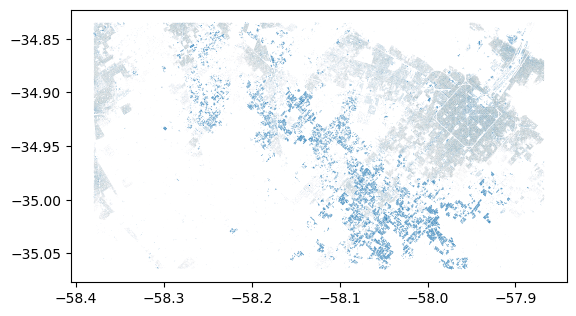

In [11]:
buildings.plot()